In [ ]:
#This script calculates the mean of the pulls and std of the pulls to show the bias
#It has all the functions and the actual test of the different parameters that you can change.


In [1]:
import numpy as np
import matplotlib.pylab as plt
import math as math
from scipy.optimize import fmin
from iminuit import Minuit, describe, Struct

import time

#import lichen as lch
import seaborn as sns

%matplotlib  notebook

In [2]:
# Add code to the following function so that it takes in two datasets, loops over one of them, and finds
# information about the nearest neighbors in the other dataset, based on a flag. 

def nn(data0,data1,r=None,nneighbors=None):
    
    ret = -1
    ret_list=[]
    if r is not None and nneighbors is not None:
        exit(-1)
        return ret
    elif r is not None and nneighbors is None:
        rsq = r*r
        for d in data0.transpose():
            count=0
            diffx=d[0]-data1[0]
            diffy=d[1]-data1[1]
            diff= diffx*diffx + diffy*diffy
            count = len(diff[diff<rsq])
            ret_list.append(float(count)/(float(len(data1[0]))*r))
        ret_list = np.array(ret_list)

        return ret_list
    elif r is None and nneighbors is not None:
        for num0 in data0:
            diff = np.abs(num0 - data1)
            diff.sort()
            radius= diff[nneighbors-1]
            ret_list.append(1/radius)
        ret_list = np.array(ret_list)
        return ret_list
    return ret

In [3]:
def normal(x,mean,width):
    return (1.0/(width*np.sqrt(2*np.pi)))*(np.exp(-(x-mean)**2/(2*(width**2))))

# A product of two Gaussians
def signal_2D(npts,means,sigmas):
    pts = []
    for m,s in zip(means,sigmas):
        pts.append(np.random.normal(m,s,npts))
        
    pts = np.array(pts)
    return pts

# Flat in 2D
def background_2D(npts,lovals,hivals):
    pts = []
    for lo,hi in zip(lovals,hivals):
        width = hi-lo
        pts.append(lo + width*np.random.random(npts))
        
    pts = np.array(pts)
    return pts

# Helper function to generate signal and background at the same time
def gen_sig_and_bkg(npts,means,sigmas,lovals,hivals):
    sigpts = signal_2D(npts[0],means,sigmas)
    bkgpts = background_2D(npts[1],lovals,hivals)

    data = [sigpts[0].copy(),sigpts[1].copy()]
    data[0] = np.append(data[0],bkgpts[0])
    data[1] = np.append(data[1],bkgpts[1])
    data = np.array(data)
   
    return data

In [4]:
# Test the tools to generate the datasets.

sigpts = signal_2D(3000,[5.0,7.0],[0.1,0.1])
#sns.jointplot(sigpts[0],sigpts[1],kind='hex')

bkgpts = background_2D(10000,[3.5,5],[6,9])
#sns.jointplot(bkgpts[0],bkgpts[1],kind='hex')

data1 = [sigpts[0].copy(),sigpts[1].copy()]
data1[0] = np.append(data1[0],bkgpts[0])
data1[1] = np.append(data1[1],bkgpts[1])
data1 = np.array(data1)

#sns.jointplot(data[0],data[1],kind='hex')

In [5]:
nbkg = 1000
sigmeans = [5.0,7.0]
sigwidths = [0.2,0.2]
bkglos = [3.5,5]
bkghis = [6,9]

def calc_pull(iterations, nsig, nMC, rad):

    pull_frac_list=[]
    average_best_frac = 0
    frac = []
    fit_frac = []
    fit_frac_uncert = []
    
    frac_org = nsig/float(nsig+nbkg)
    

    for num in range(iterations):
        nsig_iteration = np.random.poisson(nsig)
        nbkg_iteration = np.random.poisson(nbkg)
        #nbkg_iteration = nbkg
        
        data = gen_sig_and_bkg([nsig_iteration,nbkg_iteration],sigmeans,sigwidths,bkglos,bkghis)
        #sns.jointplot(data[0],data[1],kind='hex')
        
        signal_points= signal_2D(nMC,sigmeans,sigwidths)
        background_points = background_2D(nMC,bkglos,bkghis)
        
        frac_iteration = float(nsig_iteration)/(float(nbkg_iteration+nsig_iteration))
        frac.append(frac_iteration)
        
        def probability(frac):
            tot_prob=[]
            ##################################################################
            # In this section, I'm using the analytic functions.
            # But we want to compare this to when we use the nearest neighbors approach
            #signal_prob =  normal(data[0],sigmeans[0],sigwidths[0])
            #signal_prob *= normal(data[1],sigmeans[1],sigwidths[1])

            #background_prob  = (1.0/(bkghis[0]-bkglos[0]))*np.ones(len(data[0]))
            #background_prob *= (1.0/(bkghis[1]-bkglos[1]))
            ##################################################################
            #####################NEAREST NEIGHBORS############################
            signal_prob=nn(data,signal_points, r=rad)
            #print len(signal_prob[signal_prob<=0])
            background_prob= nn(data,background_points, r=rad)
            #print len(background_prob[background_prob<=0])

            tot_prob.append(frac*signal_prob+ ((1-frac)*background_prob))
            #print tot_prob
            tot_prob=np.array(tot_prob)
            #tot_prob[tot_prob<=0.0] = 1e-64
            #print len(tot_prob[tot_prob<=0])
            
            return -np.log(tot_prob[tot_prob>0]).sum()
        
        m=Minuit(probability, frac= 0.05, limit_frac=(0.001,1), error_frac=0.001,  errordef = 0.5, print_level=0)
        m.migrad()
        #m.hesse()

        if (m.get_fmin().is_valid):
            param=m.values
            err=m.errors
            fit_frac.append(param["frac"])
            fit_frac_uncert.append(err["frac"])

            #print frac_org,frac_iteration,param["frac"],err["frac"]
            pull_frac=(frac_org-param["frac"])/err["frac"]
            pull_frac_list.append(pull_frac)
    return pull_frac_list, frac, fit_frac, fit_frac_uncert,iterations

In [6]:
means=[]
stds=[]

for sig in [200]:
    for MC in [5000]:
        start = time.time()
        for rad in [0.1]: #, 0.10,0.20,0.50]:
            
            print 'number of signal points: %s \t number of MC point: %s \tradius: %s' % (sig,MC,rad)
            pulls,org_vals,fit_vals,fit_uncerts,iteration = calc_pull(10, sig, MC, rad)

            parameters_mean = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls)}
            means.append(parameters_mean)
            parameters_std = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls)}
            stds.append(parameters_std)
        print "time to calc 10 iterations: %f s" % (time.time() - start)
print means
print stds

#WITH THE POISSON and 100 iterations- TESTING IT

number of signal points: 200 	 number of MC point: 5000 	radius: 0.1
time to calc 10 iterations: 10.012109 s
[{'signal': 200, 'radius': 0.1, 'mean pulls': -0.72263003268226866, 'MC_points': 5000}]
[{'signal': 200, 'radius': 0.1, 'mean stds': 0.79692434490925956, 'MC_points': 5000}]


<IPython.core.display.Javascript object>


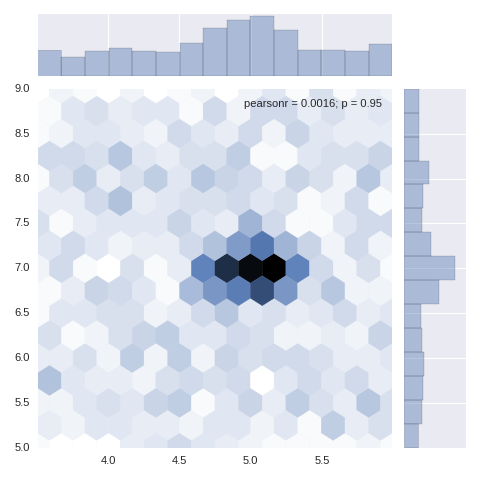

<IPython.core.display.Javascript object>


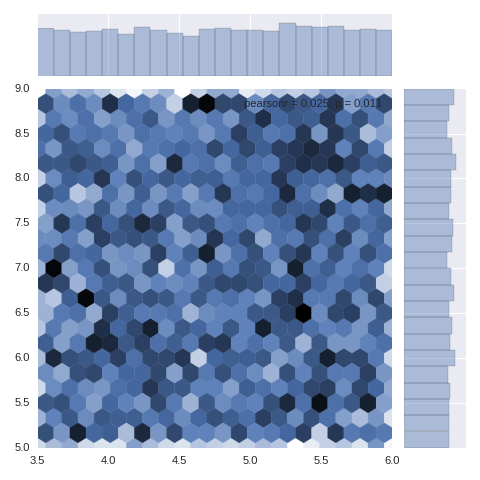

In [7]:
data = gen_sig_and_bkg([300,1000],sigmeans,sigwidths,bkglos,bkghis)
sns.jointplot(data[0],data[1],kind='hex')

#signal_points= signal_2D(10000,sigmeans,sigwidths)
background_points = background_2D(10000,bkglos,bkghis)
sns.jointplot(background_points[0],background_points[1],kind='hex')
